In [206]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

In [207]:
df = pd.read_csv("rap_df.csv").drop('Unnamed: 0', axis=1)
df.head()

,danceability,energy,loudness,musical_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,explicit,popular,duration_per_num_sections,key__1,key__2,key__3,key__4,key__5,key__6,key__7,key__8,key__9,key__10,key__11,time_sig__1,time_sig__3,time_sig__4,time_sig__5,no_instruments
0,0.320,0.934,-4.363,0,0.246,0.13400,0.000000,0.0925,0.495,138.982,196476,0,0,21830.666667,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1,0.282,0.579,-12.653,0,0.380,0.05240,0.000812,0.0977,0.205,178.866,386556,0,0,20345.052632,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0.548,0.724,-6.681,0,0.275,0.39000,0.000000,0.4690,0.481,110.066,516000,1,0,25800.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
3,0.735,0.890,-4.886,0,0.252,0.14800,0.000000,0.3140,0.565,122.014,572547,1,0,28627.350000,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4,0.713,0.883,-5.407,0,0.265,0.00588,0.000020,0.7240,0.452,124.967,338627,1,0,19919.235294,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


#### Recal the class imbalance and decide how to address
- I do not intend to use SMOTE. This artificially creates songs, and I don't want to artificially create songs that are considered popular. I do not believe a machine can accurately replicate a good song by simply using KNN to create new observations.
- I will likely use both upsampling and class weight = balanced as means to address class imbalance

### Create feature and target data, scaled and unscaled

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import StandardScaler

In [209]:
X = df.drop('popular', axis=1)
y = df.popular

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [211]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Create upsampled feature and target data, scaled and unscaled

In [212]:
from sklearn.utils import resample

In [213]:
popular = df[df.popular == 1]
not_popular = df[df.popular == 0]

In [214]:
popular_upsampled = resample(popular,
                          replace=True, # sample with replacement
                          n_samples=len(not_popular), # match number in majority class
                          random_state=42) 

In [215]:
upsampled = pd.concat([not_popular, popular_upsampled])
upsampled.popular.value_counts()

1    771
0    771
Name: popular, dtype: int64

In [216]:
X_upsampled = upsampled.drop('popular', axis=1)
y_upsampled = upsampled.popular

In [217]:
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_upsampled, 
                                                                y_upsampled, test_size=0.20, random_state=42)

In [218]:
scaler = StandardScaler()
X_train_up_scaled = scaler.fit_transform(X_train_up)
X_test_up_scaled = scaler.transform(X_test_up)

### Make a quick function to print accuracy, f1, recall, precision

In [219]:
def print_score(y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")

### Try a LogReg Gridsearch

In [220]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

#### Upsampled

In [274]:
upsampled_lr = LogisticRegressionCV(solver='liblinear', cv=10, penalty='l1', Cs = [.001,.01,.1,1,10,100], 
                                    max_iter=10000, verbose=True, n_jobs=-1, scoring='f1')

In [275]:
upsampled_lr.fit(X_train_up_scaled, y_train_up)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10, 100], cv=10, max_iter=10000,
                     n_jobs=-1, penalty='l1', scoring='f1', solver='liblinear',
                     verbose=True)

In [276]:
upsampled_lr.C_

array([1.])

In [277]:
pred = upsampled_lr.predict(X_test_up_scaled)
print_score(y_test_up, pred)

Accuracy: 0.6634304207119741
F1 Score: 0.6904761904761905
Recall: 0.7631578947368421
Precision: 0.6304347826086957


In [278]:
print(confusion_matrix(y_test_up, pred))
print('---------------------------')
print(classification_report(y_test_up, pred))


[[ 89  68]
 [ 36 116]]
---------------------------
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       157
           1       0.63      0.76      0.69       152

    accuracy                           0.66       309
   macro avg       0.67      0.67      0.66       309
weighted avg       0.67      0.66      0.66       309



In [279]:
#print(lr_clf_weighted.coef_.reshape(29))
#print(X.columns)
features_coefs = zip(X.columns, upsampled_lr.coef_.reshape(29))
coefs_df = pd.DataFrame(features_coefs, columns = ['feature', 'coef'])
coefs_df = coefs_df.sort_values(by = 'coef')

In [280]:
for_bar = pd.concat([coefs_df.head(20), coefs_df.tail(5)]) #Non-zero coefficients

Text(0, 0.5, '')

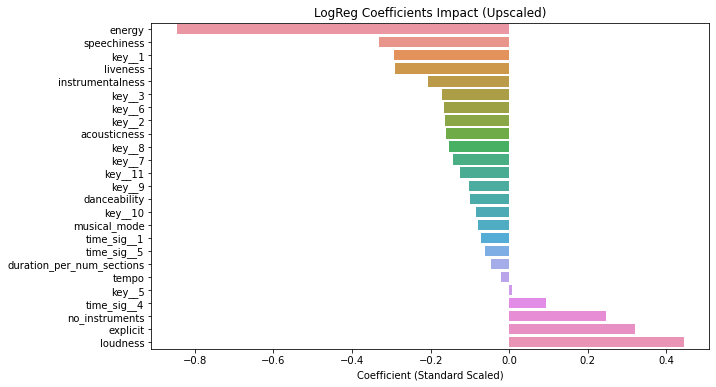

In [281]:
plt.figure(figsize=(10,6))
sns.barplot(x='coef', y='feature', data=for_bar)
plt.title('LogReg Coefficients Impact (Upscaled)')
plt.xlabel('Coefficient (Standard Scaled)')
plt.ylabel('')

I am optimizing for f1 score. Unlike industries such as healthcare or predicting credit card fraud, I do not believe that recall / precision importance far outweighs the other. If we have a high recall, then we did well in the sense that our model predicts popular songs well out of all songs that should be popular. This is important -- we do not want to miss label songs that truly are popular. If we have high precision, than of all the songs we predicted to be true, X% turned out to actually be true. While in my opinion less important than recall, I think this is not something to be pushed aside. Hence, I will optimize for f1.

From the above model, the best result from logistic upscaled regression utilized unscaled (scaled resulted in roughly the same but slightly worse -- 89 in the true negative instead of 90). However, for the sake of a chart to show coefficients, I will use the scaled data.

76% recall is not bad, but I will continue trying other models as the notebook progresses.

#### Weighted

In [285]:
lr_clf_weighted = LogisticRegressionCV(solver='liblinear', class_weight='balanced', Cs = [.001,.01,.1,1,10,100],
                                      cv=10, penalty='l1', scoring = 'f1', max_iter=10000,
                                       verbose=True, n_jobs=-1)

In [286]:
lr_clf_weighted.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10, 100], class_weight='balanced',
                     cv=10, max_iter=10000, n_jobs=-1, penalty='l1',
                     scoring='f1', solver='liblinear', verbose=True)

In [287]:
lr_clf_weighted.C_

array([0.1])

In [288]:
pred = lr_clf_weighted.predict(X_test_scaled)
print_score(y_test, pred)

Accuracy: 0.6302521008403361
F1 Score: 0.5925925925925926
Recall: 0.810126582278481
Precision: 0.46715328467153283


In [289]:
print(confusion_matrix(y_test, pred))
print('---------------------------')
print(classification_report(y_test, pred))

[[86 73]
 [15 64]]
---------------------------
              precision    recall  f1-score   support

           0       0.85      0.54      0.66       159
           1       0.47      0.81      0.59        79

    accuracy                           0.63       238
   macro avg       0.66      0.68      0.63       238
weighted avg       0.72      0.63      0.64       238



In [290]:
#print(lr_clf_weighted.coef_.reshape(29))
#print(X.columns)
features_coefs = zip(X.columns, lr_clf_weighted.coef_.reshape(29))
coefs_df = pd.DataFrame(features_coefs, columns = ['feature', 'coef'])
coefs_df = coefs_df.sort_values(by = 'coef')

In [291]:
for_bar = pd.concat([coefs_df.head(11), coefs_df.tail(7)]) ## Non-zero coefficients

Text(0, 0.5, '')

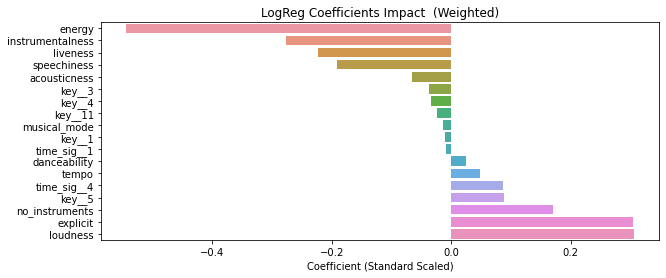

In [292]:
plt.figure(figsize=(10,4))
sns.barplot(x='coef', y='feature', data=for_bar)
plt.title('LogReg Coefficients Impact  (Weighted)')
plt.xlabel('Coefficient (Standard Scaled)')
plt.ylabel('')

Precision suffered a lot in this model, and accuracy went down as well. However, Recall is our best yet. I probably prefer the first model to this one.

### Try a Pruned Decision Tree on Upsampled Data

In [320]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import GridSearchCV

In [298]:
decision_tree = DecisionTreeClassifier()
# creating our parameters to test
# note these values have been iterrated through multiple times and this cell represents the final state
param_dict={'max_depth': [8,9,10,11],
            'min_samples_leaf' : [1,2],
            'criterion': ['gini'], 
            'min_samples_split' : [6,7,8],
            'max_features': [8,9,10]}

In [299]:
#create the instance of GridSearchCV using the recall metric for our scoring. 
grid_tree=GridSearchCV(decision_tree, param_dict, cv=10, scoring='f1', n_jobs=-1, verbose=1)
#fit the Gridsearch to our data
grid_tree.fit(X_train_up ,y_train_up)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 697 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    2.7s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [8, 9, 10, 11],
                         'max_features': [8, 9, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [6, 7, 8]},
             scoring='f1', verbose=1)

In [300]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

0.7625605869593787
{'criterion': 'gini', 'max_depth': 11, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 6}
DecisionTreeClassifier(max_depth=11, max_features=9, min_samples_split=6)


In [301]:
pred = grid_tree.best_estimator_.predict(X_test_up)
print_score(y_test_up, pred)

Accuracy: 0.6828478964401294
F1 Score: 0.7083333333333333
Recall: 0.7828947368421053
Precision: 0.6467391304347826


In [302]:
print(confusion_matrix(y_test_up, pred))
print('---------------------------')
print(classification_report(y_test_up, pred))

[[ 92  65]
 [ 33 119]]
---------------------------
              precision    recall  f1-score   support

           0       0.74      0.59      0.65       157
           1       0.65      0.78      0.71       152

    accuracy                           0.68       309
   macro avg       0.69      0.68      0.68       309
weighted avg       0.69      0.68      0.68       309



In [326]:
features_coefs = zip(X.columns, grid_tree.best_estimator_.feature_importances_)
coefs_df = pd.DataFrame(features_coefs, columns = ['feature', 'coef'])
coefs_df = coefs_df.sort_values(by = 'coef')

In [329]:
for_bar = coefs_df[coefs_df.coef != 0]## Non-zero coefficients

Text(0, 0.5, '')

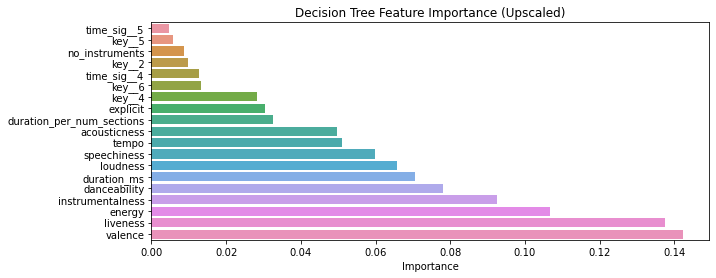

In [330]:
plt.figure(figsize=(10,4))
sns.barplot(x='coef', y='feature', data=for_bar)
plt.title('Decision Tree Feature Importance (Upscaled)')
plt.xlabel('Importance')
plt.ylabel('')

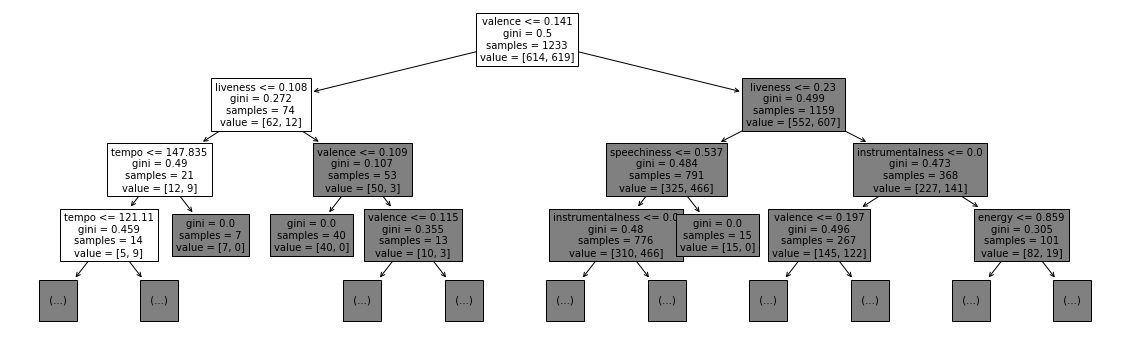

In [365]:
# Decision tree is huge so we can't nicely visualize it all, but the below it just to get an idea of the 
# first few layers
plt.figure(figsize=(20,6))
plot_tree(grid_tree.best_estimator_, max_depth=3, fontsize=10, feature_names=X.columns)
plt.show()

This is not the best model in terms of recall, but from an overall standpoint, this is definitely the best model yet. Best accuracy and best f1 while still quite a good recall.

As seen in the feature importance plot, decision trees weight the features a little differently than the logistic regression did for our upscaled data. In logistic regression, not having any instruments had a relatively big effect on the model, but in decision trees, it is much less.

### Try a Pruned Decision Tree on Weighted Data

### Try a Random Forest

### Try an XGBoost

### Try a Voting Classifier